In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
S0 = 14
K = 15
r = 0.1
sigma = 0.25
T = 0.2
gamma = 1
num_paths = 10000 #Assumed value
num_steps = 1000 #Assumed value
dt = T / num_steps

In [3]:
from numpy import exp, log, sqrt, mean
from scipy.special import erf

def bsexact(sigma: float, R: float, K: float, T: float, s: float):
  d1 = (log(s/K)+(R+0.5*sigma**2)*T)/(sigma*sqrt(T))
  d2 = d1-sigma*sqrt(T)
  F = 0.5*s*(1+erf(d1/sqrt(2)))-exp(-R*T)*K*0.5*(1+erf(d2/sqrt(2)))
  return F

In [4]:
# Monte Carlo Euler method
def euler_call_price(S0, K, r, sigma, T, gamma, num_paths, num_steps):
    dt = T / (num_steps-1)
    payoffs = np.zeros(num_paths)

    for i in range(num_paths):
        S = S0
        for _ in range(num_steps):
            Z = np.random.randn()
            S = S + r * S * dt + sigma * (S**gamma) * sqrt(dt) * Z
        payoffs[i] = max(S - K, 0)

    call_price = exp(-r * T) * mean(payoffs)
    return call_price

In [14]:
path_counts = [100, 500, 1000, 5000, 10000, 20000]
prices = [euler_call_price(S0, K, r, sigma, T, gamma, n, num_steps) for n in path_counts]
errors_normal = prices - bsexact(sigma, r, K, T, S0)
slope_normal = np.round(np.polyfit(np.log(np.absolute(path_counts)),np.log(np.absolute(errors_normal)),1)[0],2)

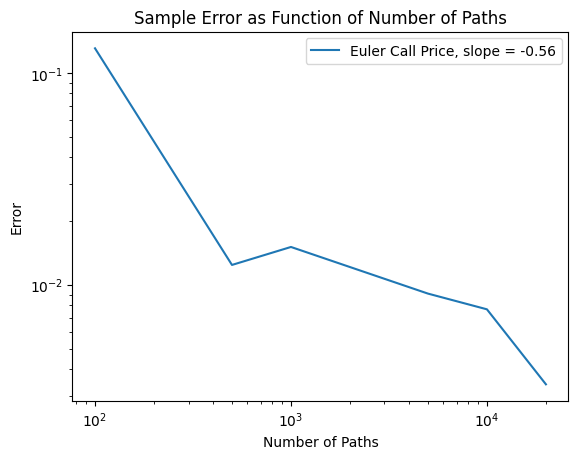

In [ ]:
# Plot sample error as function of number of paths
plt.figure()
plt.loglog(path_counts, np.absolute(errors_normal), label=f"Euler Call Price, slope = {slope_normal}")
#plt.axhline(y=bsexact(sigma, r, K, T, S0), color='black', label="Exact Price (gamma=1)")
plt.xlabel("Number of Paths")
plt.ylabel("Error")
plt.legend()
plt.title("Sample Error as Function of Number of Paths")
plt.show()

The numerical simulation seems to converge to the analytical solution at the expected rate.

In [ ]:
step_counts = [10,50,100,200,500]
prices_steps = [euler_call_price(S0, K, r, sigma, T, gamma, 1000, n) for n in step_counts]
errors = np.absolute(prices_steps - bsexact(sigma, r, K, T, S0))
print(prices_steps)
slope = np.round(np.polyfit(np.log(step_counts),np.log(errors),1)[0],2)

[0.40019585340100294, 0.39816823223387615, 0.35648392269030044, 0.35500705517280734, 0.34787106065104695]


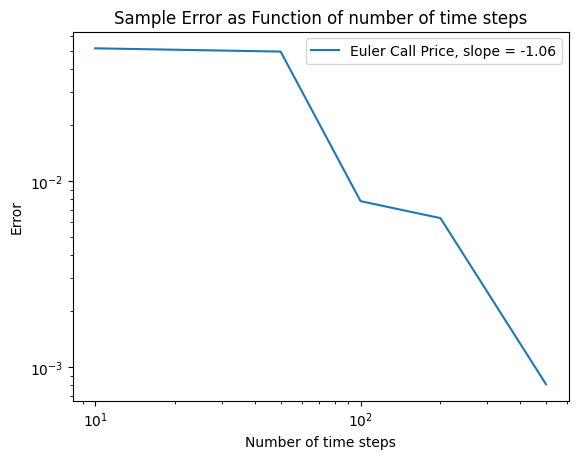

In [ ]:
# Plot discretization error as function of time step
plt.figure()
plt.loglog(step_counts, np.absolute(errors), label=f"Euler Call Price, slope = {slope}")
#plt.axhline(y=bsexact(sigma, r, K, T, S0), color='black', label="Exact Price (gamma=1)")
plt.xlabel("Number of time steps")
plt.ylabel("Error")
plt.legend()
plt.title("Sample Error as Function of number of time steps")
plt.show()

Now the solution seems to converge linearly, which is expected of the euler forward. (to be honest this could be dumb luck, since RK4 further down does not converge at the expected rate. The sample error seems to be the dominating factor).

In [15]:


# Antithetic variates
def antithetic_call_price(S0, K, r, sigma, T, gamma, num_paths, num_steps):
    dt = T / num_steps
    payoffs = np.zeros(num_paths)

    for i in range(0, num_paths, 2):
        S1 = S0
        S2 = S0
        for _ in range(num_steps):
            Z = np.random.randn()
            S1 = S1 + r * S1 * dt + sigma * S1**gamma * np.sqrt(dt) * Z
            S2 = S2 + r * S2 * dt + sigma * S2**gamma * np.sqrt(dt) * (-Z)  # Antithetic
        payoffs[i] = max(S1 - K, 0)
        payoffs[i+1] = max(S2 - K, 0)

    call_price = np.exp(-r * T) * np.mean(payoffs)
    return call_price

antithetic_prices = [antithetic_call_price(S0, K, r, sigma, T, gamma, n, num_steps) for n in path_counts]
errors_anti = antithetic_prices - bsexact(sigma, r, K, T, S0)
slope_anti = np.round(np.polyfit(np.log(np.absolute(path_counts)),np.log(np.absolute(errors_anti)),1)[0],2)

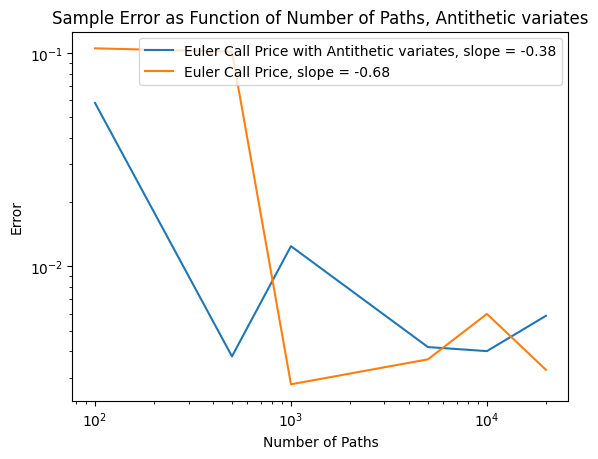

In [16]:
plt.figure()
#plt.plot(path_counts, prices, label="Euler Call Price")
plt.loglog(path_counts, np.absolute(errors_anti), label=f"Euler Call Price with Antithetic variates, slope = {slope_anti}")
plt.loglog(path_counts, np.absolute(errors_normal), label=f"Euler Call Price, slope = {slope_normal}")
#plt.axhline(y=bsexact(sigma, r, K, T, S0), color='black', label="Exact Price (gamma=1)")
plt.xlabel("Number of Paths")
plt.ylabel("Error")
plt.legend()
plt.title("Sample Error as Function of Number of Paths, Antithetic variates")
plt.show()

By looking at the figure, it is hard to draw any relevant conclusions. The antithetic variate seems to matter more for smaller sample sizes. There's not a big difference between the two graphs. We tried to run the simulation a lot of times with different parameters but they did not want to show a nice behavior. Perhaps this problem does not benefit from antithetic variables. Maybe the sample sizes are to small, or the discretization error is to big.

In [ ]:
#Runge Kutta order of 4
def rk4_call_price(S0, K, r, sigma, T, gamma, num_paths, num_steps):
    dt = T / num_steps
    payoffs = np.zeros(num_paths)
    for i in range(num_paths):
        S = S0
        for _ in range(num_steps):
            Z = np.random.randn()
            # RK4 steps
            k1 = r * S * dt + sigma * S**gamma * np.sqrt(dt) * Z
            k2 = r * (S + 0.5 * k1) * dt + sigma * (S + 0.5 * k1)**gamma * np.sqrt(dt) * Z
            k3 = r * (S + 0.5 * k2) * dt + sigma * (S + 0.5 * k2)**gamma * np.sqrt(dt) * Z
            k4 = r * (S + k3) * dt + sigma * (S + k3)**gamma * np.sqrt(dt) * Z
            S = S + (k1 + 2*k2 + 2*k3 + k4) / 6
        payoffs[i] = max(S - K, 0)

    call_price = np.exp(-r * T) * np.mean(payoffs)
    return call_price

step_counts = [10,50,100,200,500,1000]
rk4_prices = [rk4_call_price(S0, K, r, sigma, T, gamma, 1000, n) for n in step_counts]
errors = rk4_prices - bsexact(sigma, r, K, T, S0)
print(errors)
slope = np.round(np.polyfit(np.log(np.absolute(step_counts)),np.log(np.absolute(errors)),1)[0],2)

[0.04966514 0.04663105 0.04916278 0.02901075 0.01644057 0.03029325]


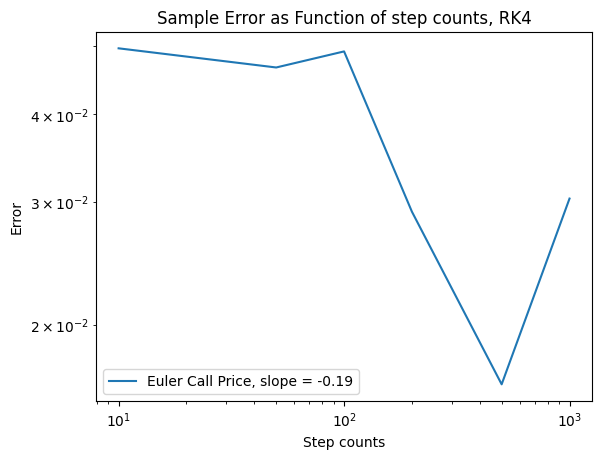

In [ ]:
plt.figure()
#plt.plot(path_counts, prices, label="Euler Call Price")
#plt.plot(path_counts, antithetic_prices, label="Antithetic Call Price", color='green')
plt.loglog(step_counts, np.absolute(errors), label=f"Euler Call Price, slope = {slope}")
#plt.axhline(y=bsexact(sigma, r, K, T, S0), color='black', label="Exact Price (gamma=1)")
plt.xlabel("Step counts")
plt.ylabel("Error")
plt.legend()
plt.title("Sample Error as Function of step counts, RK4")
plt.show()

The RK4 scheme really does not want to converge. It could be because of the sample error being larger than the time discretization error. It probably needs a lot more sample paths, but this was not feasable because the code execution time was incredibly long.

In [ ]:
gammas = np.linspace(0.5, 1.0, 10)
prices_gamma = [euler_call_price(S0, K, r, sigma, T, g, 10000, num_steps) for g in gammas]



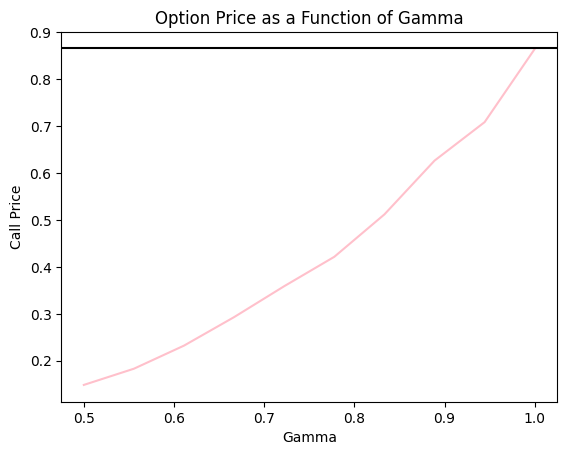

In [ ]:
plt.figure()
plt.plot(gammas, prices_gamma, label="Euler Call Price", color="pink")
plt.axhline(y=bsexact(sigma, r, K, T, S0), color='black', label="Exact Price (gamma=1)")
plt.xlabel("Gamma")
plt.ylabel("Call Price")
plt.title("Option Price as a Function of Gamma")
plt.show()

Because we modeled the volatility as inversely correlated with the price for gamma, it makes sense that the price would decrease for smaller valuse of gamma.